#  Deep Learning and Image Recognition

https://blog.keras.io/building-autoencoders-in-keras.html

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data forma

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.

In [3]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Instructions for updating:
Use the retry module or similar alternatives.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 140us/step - loss: 0.2175 - val_loss: 0.1753
Epoch 2/50
60000/60000 [==============================] - 7s 117us/step - loss: 0.1584 - val_loss: 0.1460
Epoch 3/50
60000/60000 [==============================] - 12s 207us/step - loss: 0.1412 - val_loss: 0.1335
Epoch 4/50
60000/60000 [==============================] - 13s 224us/step - loss: 0.1324 - val_loss: 0.1244
Epoch 5/50
60000/60000 [==============================] - 15s 247us/step - loss: 0.1272 - val_loss: 0.1241
Epoch 6/50
60000/60000 [==============================] - 14s 241us/step - loss: 0.1237 - val_loss: 0.1203
Epoch 7/50
60000/60000 [==============================] - 15s 244us/step - loss: 0.1211 - val_loss: 0.1206
Epoch 8/50
60000/60000 [==============================] - 14s 236us/step - loss: 0.1189 - val_loss: 0.1156
Epoch 9/50
60000/60000 

The model converges to a loss of 0.094, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:

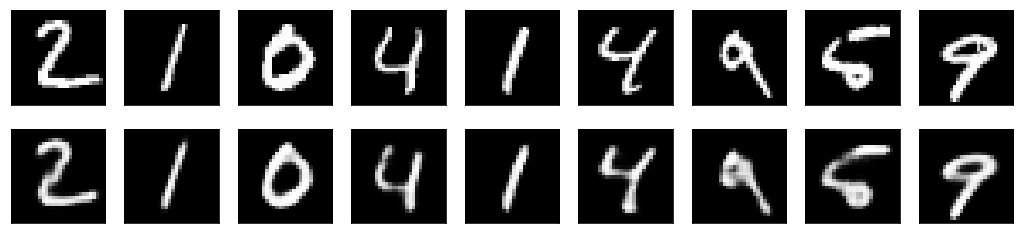

In [8]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Application to image denoising

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [10]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Here's what the noisy digits look like:

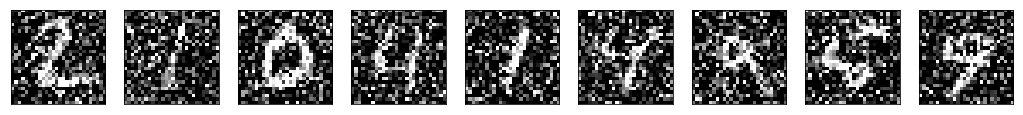

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

In [13]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's train it for 100 epochs:

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 15s 254us/step - loss: 0.1798 - val_loss: 0.1220
Epoch 2/100
60000/60000 [==============================] - 19s 318us/step - loss: 0.1183 - val_loss: 0.1152
Epoch 3/100
60000/60000 [==============================] - 17s 279us/step - loss: 0.1111 - val_loss: 0.1109
Epoch 4/100
60000/60000 [==============================] - 18s 295us/step - loss: 0.1077 - val_loss: 0.1051
Epoch 5/100
60000/60000 [==============================] - 16s 274us/step - loss: 0.1052 - val_loss: 0.1039
Epoch 6/100
60000/60000 [==============================] - 17s 284us/step - loss: 0.1037 - val_loss: 0.1020
Epoch 7/100
60000/60000 [==============================] - 20s 331us/step - loss: 0.1027 - val_loss: 0.1002
Epoch 8/100
60000/60000 [==============================] - 19s 324us/step - loss: 0.1018 - val_loss: 0.1020
Epoch 9/100
60000/60000 [==============================] - 19s 315us/step - loss: 0.10

Epoch 76/100
60000/60000 [==============================] - 18s 307us/step - loss: 0.0946 - val_loss: 0.0944
Epoch 77/100
60000/60000 [==============================] - 16s 268us/step - loss: 0.0946 - val_loss: 0.0942
Epoch 78/100
60000/60000 [==============================] - 16s 270us/step - loss: 0.0946 - val_loss: 0.0942
Epoch 79/100
60000/60000 [==============================] - 16s 270us/step - loss: 0.0945 - val_loss: 0.0956
Epoch 80/100
60000/60000 [==============================] - 17s 279us/step - loss: 0.0945 - val_loss: 0.0940
Epoch 81/100
60000/60000 [==============================] - 17s 278us/step - loss: 0.0945 - val_loss: 0.0941
Epoch 82/100
60000/60000 [==============================] - 16s 266us/step - loss: 0.0945 - val_loss: 0.0951
Epoch 83/100
60000/60000 [==============================] - 16s 269us/step - loss: 0.0945 - val_loss: 0.0945
Epoch 84/100
60000/60000 [==============================] - 16s 267us/step - loss: 0.0944 - val_loss: 0.0940
Epoch 85/100
60000/

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

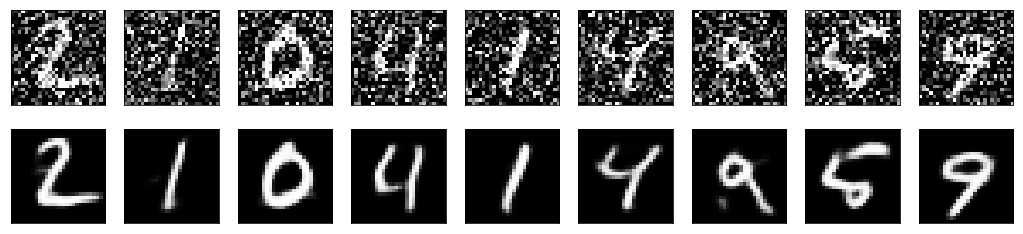

In [17]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()